# Etude numérique d'un filtre linéaire

__But :__ Simuler, à l'aide d'un langage de programmation, l'action d'un filtre sur un signal périodique. Mettre en évidence l'influence des caractéristiques du filtre sur l'opération de filtrage.

## Fonctions utiles

Cette activité fait suite à l'activité où vous avez appris à reconstruire un signal à partir des ses composantes spectrales. Pour gagner du temps les fonctions utiles qui avaient déjà été implémentées sont redonnées ici.

In [1]:
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write  # Pour importer et écrire un fichier son wav

def fonc_temp(t, fs, amps, phis):
    """
    Renvoie la somme des composantes spectrales définies par
    - leurs fréquences freqs
    - leurs amplitudes amprs
    - leurs phases à l'origine phis
    et le calcul à un temps t.
    Cette fonction est vectorialisable : t peut-être un vecteur numpy
    """
    n = len(fs)  # Nombre de composantes spectrales
    s = 0  # Initialisation de la valeur du signal
    for i in range(n):  # On va parcourir les composantes
        if i % 2000 == 0:
            print("{:.0f} %".format(i / n * 100))
        s += 2 * amps[i] * np.cos(2 * np.pi * fs[i] * t + phis[i])  # On ajoute la composante spectrale
    return s


def evalue_temp(fs, amps, phis, t1, t2, N):
    """
    Renvoie deux vecteurs : 
    - un vecteur de N valeurs de temps tk entre t1 et t2
    - un vecteur donnant le signal reconstruit à partir de 
    (fs(fréquence), amps(amplitudes), phis(phase à l"origine))
    calculé aux temps tk
    """
    ts = np.linspace(t1, t2, N)  # Création du vecteur temps
    return ts, fonc_temp(ts, fs, amps, phis)  # Les opérations de evalue_temp sont toutes vectorialisables


def eval_fft(s, fe):
    """
    Calcul la transformée de Fourier du signal donnée par le vecteur s et échantillonné à la fréquence fe
    Il renvoie :
    - la liste de fréquences
    - la liste des amplitudes (jusqu'à fe/2)
    - la liste des phases à l'origine
    Pour un vecteur s de taille N, la taille de la décomposition sera int(N/2) 
    avec un pas de fréquence fe / N
    """
    N = len(s)  # Taille de s pour le vecteur des fréquences
    freqs = np.arange(int(N / 2)) * fe / N  # Liste de fréquence
    sk = fft(s) / N  # Calcul de la TF
    return freqs, np.abs(sk)[:int(N/2)] * 2, np.angle(sk)[:int(N/2)]

## Position du problème
### Signal étudié.
Le signal considéré est téléchargeable par [ce lien](https://github.com/pcsi3physiquestan/donnees_exp/blob/main/signal_bruitee.wav?raw=true). Vous pouvez l'écouter avec VLC ou Audacity : il s'agit un très court extrait d'une musique fortement bruitée.

_Note : Le traitement préalable par Python des fichiers sonores n'est pas parfait et certains lecteurs risquent de ne pas lire correctement le fichier son._

Nous allons :
* transformer ce signal en un tableau numpy donnant deux signaux __temporels__ (gauche et droite).
* Analyser son tracé temporel et sa décomposition spectrale pour observer qu'est-ce qui est responsable du bruit gênant.
* Procéder à un filtrage approprié pour atténuer le bruit du signal.

### Importation d'un fichier wav
_Pensez à placer votre fichier au niveau du notebook pour pouvoir importer le fichier_.

Deux fonctions ont été importées de la bibliothèque `scipy.io.wavfile`:
* `read(chemin_vers_fichier)` qui importe un fichier `.wav` et qui renvoie deux éléments :
    * la fréquence d'échantillonnage
    * un tableau numpy contenant deux lignes : chacune représente le signal sonore temporel respectivement gauche et droite. Les valeurs sont des __flottants compris entre -1 et 1__.
* `write(chemin_vers_fichier, samplerate, data)` qui va écrire dans un fichier .`wav` (il faudra lui donner la bonne extension et choisir un nom __different du fichier d'entrée__ le fichier son correspondant à data :
    * `samplerate` est la fréquence d'échantillonnage
    * `data` est un tableau numpy contenant 2 lignes donnant le signal sonore temporel gauche et droite. Les valeurs devront être des __flottants compris entre -1 et 1__.

## Analyse du signal bruité
> __Exercice 1 :__  
> Vous devez :
> 1. Afficher la fréquence d'échantillonnage du signal et le nombre de points de mesures. En déduire la durée de l'extrait sonore
> 2. Pour chaque signal gauche et droite, tracer l'allure temporelle sur deux graphiques séparées (vous pouvez utiliser une fenêtre multigraphique). Pouvez-vous observer sur le signal temporel que le signal est bruité ?
> 3. Pour chaque signal gauche et droite, obtenir le spectre grâce à la fonction `eval_fft` et la représenter  (vous pouvez utiliser une fenêtre multigraphique). Quelle bande spectrale correspond selon vous au bruit à supprimer ? Quel type de filtre va-t-on utiliser ?

/tmp/ipykernel_16003/145008752.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, datas = read(filename)


--------------
Fréquence d'échantilonnage : 8000 ech/s
--------------


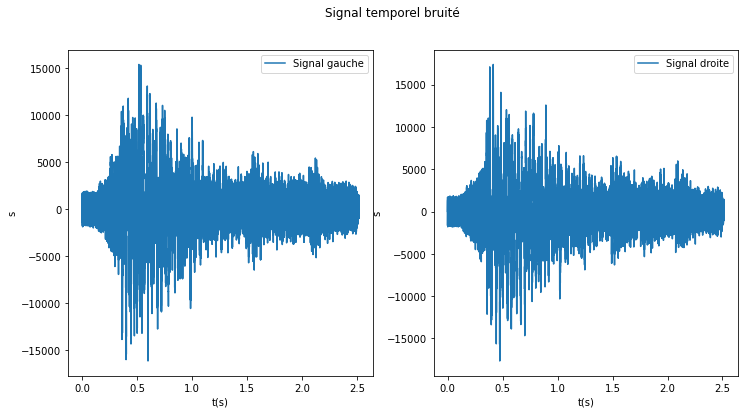

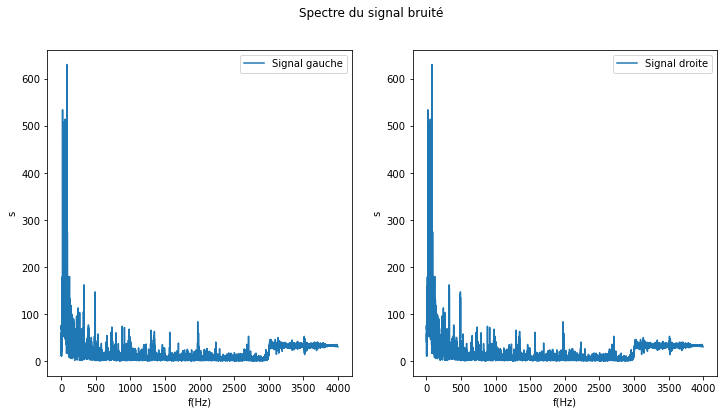

In [2]:
"""Les bibliothèques utiles ont déjà été importées."""

"""Les instructions suivantes chargent les données du fichier wav.
"""
filename = 'sources/signal_bruitee_2.wav'  # Entrer ici le chemin relatif vers le fichier sonore téléchargé
samplerate, datas = read(filename)

print('--------------')
print("Fréquence d'échantilonnage : {} ech/s".format(samplerate))
print('--------------')

"""Séparation des signaux gauche et droite"""
gauche = datas[:, 0]  # Signal gauche
droite = datas[:, 1]  # Signal droite
npt = len(gauche)  # Nombre de points du signal

"""Tracé temporel"""
ts = np.arange(npt) * 1 / samplerate  # Création du vecteurs des temps
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Signal temporel bruité")
ax[0].set_xlabel("t(s)")
ax[0].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[0].plot(ts, gauche, label="Signal gauche")
ax[0].legend()
ax[1].set_xlabel("t(s)")
ax[1].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[1].plot(ts, droite, label="Signal droite")
ax[1].legend()
plt.show()


"""Tracé fréquentielle"""
freqs_g, amps_g, phis_g = eval_fft(gauche, samplerate)  # On utilise la fonction donnée
freqs_d, amps_d, phis_d = eval_fft(gauche, samplerate)  # On utilise la fonction donnée

f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Spectre du signal bruité")
ax[0].set_xlabel("f(Hz)")
ax[0].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[0].plot(freqs_g, amps_g, label="Signal gauche")
ax[0].legend()
ax[1].set_xlabel("f(Hz)")
ax[1].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[1].plot(freqs_d, amps_d, label="Signal droite")
ax[1].legend()
plt.show()

* Le signal temporel ne donne pas beaucoup d'informations.
* On peut raisonnablement penser que les fortes amplitudes aux hautes fréquences (après 2500Hz) correspondent aux bruits et que c'est ce que nous allons devoir filtrer. On va donc utiliser un filtre passe-bas.

## Dimensionnement du filtre.
On va considérer qu'il convient :
* de garder un gain supérieur à $G_1 = 0.9$ au dessous de $f_1 = 1500Hz$.
* d'avoir un gain inférieur à $G_2 = 0.05$ au dessus de $f_2 = 2500Hz$.

### Choix du filtre
Le filtre que nous allons choisir est un filtre passe-bas dit de Butterworth d'ordre n. Comme expliqué en devoir libre, il a les caractéristiques suivantes :
* son gain réel s'écrit sous la forme : $G = {1 \over \sqrt{1 + x^{2n}}}$ avec $x = {\omega \over \omega_c}$ et $\omega_c$ la pulsation de coupure du filtre.

L'intérêt est que quelque soit l'ordre choisi, la pulsation de coupure sera la même. On pourra donc étudier l'influence de l'ordre du filtre sans devoir réadapter sa pulsation de coupure.

Pour obtenir un tel gain réel, la fonction de transfert pour un filtre d'ordre $n$ doit s'écrire sous la forme :

$$
H(j\omega) = {1 \over \prod_{k=1}^{k=n} \left({j \omega \over \omega_c} - p_k\right)} = {1 \over \prod_{k=1}^{k=n} \left({j f \over f} - p_k\right)}
$$

avec $p_k = \exp\left( {j (2k + n -1 }) \pi \over 2n\right)$ et $f_c$ la fréquence de coupure du filtre.

### Ordre du filtre
__Exercice 2:__  
(Pensez à bien lire les indications)
1. Ecrire une fonction `butterworth` qui renvoie la fonction de transfert complexe d'un filtre de Butterworth d'ordre `n` calculé en une fréquence `f` et qui prend comme argument :
    * `f` la fréquence où on veut calculer la fonction de transfert.
    * `fc` la fréquence du coupure du filtre.
    * `n` l'ordre du filtre
2. En utilisant la fonction `logspace` de `numpy`, créer un vecteur de fréquence régulièrement répartie sur un axe logarithmique entre 100Hz et 10kHz. Puis utiliser ce vecteur pour tracer le diagramme de Bode en gain pour un filtre de Butterworth d'ordre 1. Vérifier qu'on a bien le tracé de la fonction de transfert $H(j\omega) = {1 \over 1 + j {\omega \over \omega_c}}$.  

La grandeur $\eta = {G(f_2)^{-2} - 1 \over G(f_1)^{-2} - 1}$ pour un filtre de Butterworth d'ordre $n$ ne dépend pas de la fréquence de coupure, mais uniquement du rapport $f_2 /f_1$ et de l'ordre $n$ du filtre (on s'entraînera chez soi à le démontrer).  
On peut montrer de plus que le cahier des charges impose que $\eta > {G_2^{-2} - 1 \over G_1^{-2} - 1}$

3. Utiliser le calcul numérique de $\eta$ et écrire un script qui détermine l'ordre $n_{min}$ minimal que doit avoir le filtre pour le cahier des charges choisi. On travaillera par la suite avec l'ordre $n_{min}$.
    

_Indications utiles :_
* La fonction `butterworth` ne doit pas être nécessairement vectorialisable en `f`, vous réaliserez une boucle pour créer un vecteur de valeurs pour plusieurs valeurs de `f`.
* Le nombre complexes $j$ tel $j^2 = -1$ s'écrit sous Python `1j` (le 1 est obligatoire et il est collé au j). Pour écrire $variable \times j$, on écrira : `variable * 1j` (ou évidemment `1j * variable`).
* Pour le diagramme de Bode :
    * Signature de `logspace` : `logspace(start, stop, N)` crée `N` fréquences uniformément répartie sur un axe logarithmique entre $10^{start}$ et $10^{stop}$.
    * Le module d'un complexe s'obtient avec la fonction `np.abs` et le logarithme décimal s'obtient par la fonction `np.log10`.
    * Le tracé d'un diagramme semi-log se fait avec la fonction `semilogx`, elle a les mêmes caractéristiques que la fonction `plot`
    * (Esthétique) Utiliser la fonction `ax.grid(which='both', axis='both')` pour afficher une grille semblable à celles vu sur les diagrammes de Bode.

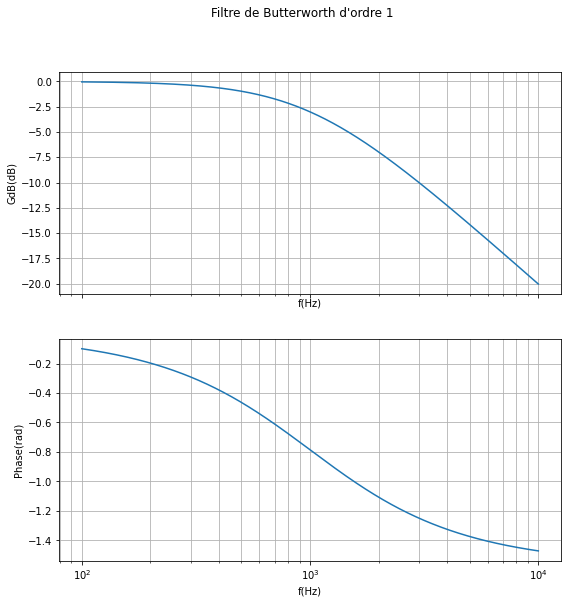

In [3]:
def butterworth(f, fc, n):
    """ Fonction qui renvoie la fonction de transfert d'un filtre de Butterworth d'ordre n et de
    fréquence de coupure fc évalué à la fréquence f."""
    h = 1  # Initialisation de la fonction de transfert
    for k in range(1, n+1):  # Attention, on doit aller de 1 à n inclus
        pk = np.exp(1j * (2*k + n - 1) * np.pi / (2 * n))
        h = h * 1 / ((1j * f / fc - pk))
    return h


"""Calcul des valeurs du filtre d'ordre 1 pour plusieurs fréquences"""
fc = 1000 # Fréquence de coupure
N = 1000  # Nombre de fréquences pour le tracé.
fr = np.logspace(2, 4, N)  # 1000 points entre 100 et 10000kHz
h_b = []  # Liste pour stocker les valeurs de H
for i in range(N):
    h_b.append(butterworth(fr[i], fc, 1))
h_b = np.array(h_b)

gain_b = np.abs(h_b)  # Calcul des gains réels.
gdb_b = 20 * np.log10(gain_b)  # Calcul des gains en décibel
phi_b = np.angle(h_b)  # BONUS :  Calcul des phases

"""Tracé graphique"""
f, ax = plt.subplots(2, 1, figsize=(9, 9), sharex='col')  # BONUS : on trace aussi le diagramme de Bode an phase
f.suptitle("Filtre de Butterworth d'ordre 1")
ax[0].set_xlabel("f(Hz)")
ax[0].set_ylabel("GdB(dB)")
ax[0].semilogx(fr, gdb_b)
ax[0].grid(which='both', axis='both')

ax[1].set_xlabel("f(Hz)")
ax[1].set_ylabel("Phase(rad)")
ax[1].semilogx(fr, phi_b)
ax[1].grid(which='both', axis='both')

On observe bien :
* une fréquence de coupure à $1kHz$*
* une asymptote de $-20dB/decade$
* un gain statique égal à 1

C'est donc bien cohérente à un filtre d'ordre 1 d'équation ${1 \over 1 + j x}$

In [4]:
"""Détermination de nmin"""
def eta(n):
    """Fonction qui calcule état pour un ordre n donné"""
    f1 = 1500
    f2 = 2500
    fc = 2000  # Puisque ça ne dépend pas de fc, on prend une valeur arbitraire
    Gf1 = np.abs(butterworth(f1, fc, n))
    Gf2 = np.abs(butterworth(f2, fc, n))
    return (Gf2 ** -2 - 1) / (Gf1 ** -2 - 1)

G1 = 0.9
G2 = 0.05
etamin = (G2 ** -2 - 1) / (G1 ** -2 - 1)

n = 1  # On démarre avec un filtre d'ordre 1
while eta(n) < etamin:  # Condition du cahier des charges
    n = n + 1
nmin = n
print('--------------')
print('Ordre minimal : {}'.format(nmin))
print('--------------')

--------------
Ordre minimal : 8
--------------


### Choix de $f_c$
_Pour toute la suite, on travaillera avec un filtre d'ordre $n_{min}$._

__Exercice 3:__  
1. Ecrire un script qui, partant d'une fréquence de coupure $f_c = f_1$ détermine la fréquence de coupure minimale telle que $G(f_1) > 0.9$. Vérifier alors que $G(f_2) < 0.1$.
2. Tracer le diagramme de Bode en gain du filtre pour $f_c$ trouvée précédemment et vérifier visuellement son ordre et que les gains en $f_1$ et $f_2$ suivent le cahier des charges.

--------------
Fréquence de coupure choisie : 1642.303466796875 Hz
Gain en f1 : 0.9000124005805714 
Gain en f2 : 0.034661405368328346 
--------------


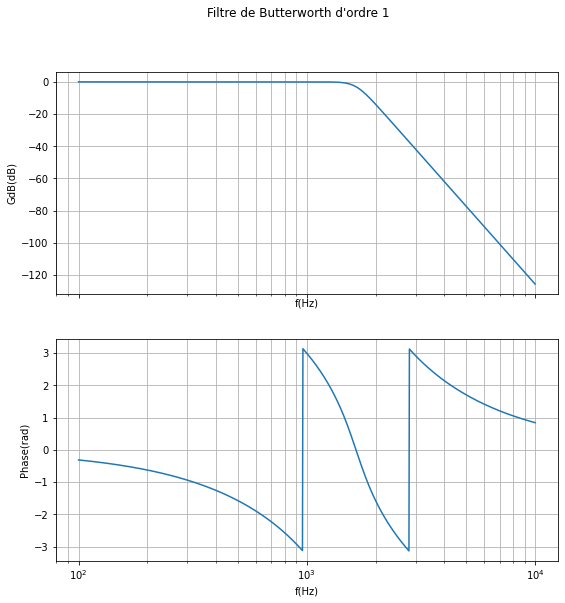

In [5]:
"""Détermination de la fréquence de coupure"""
f1 = 1500
f2 = 2500
f01 = 1500
f02 = 2500
f0c = (f01 + f02) / 2  # Initialisation
ecart = (f02 - f01)
prec = 1e-1
while ecart > prec:
    G1 = np.abs(butterworth(f1, f01, nmin)) - 0.9
    G2 = np.abs(butterworth(f1, f02, nmin)) - 0.9
    Gc = np.abs(butterworth(f1, f0c, nmin)) - 0.9
    if Gc == 0:
        f1, f2 = f0c, f0c
    elif G1 * Gc < 0:
        f02 = f0c
        f0c = (f01 + f02) / 2
    else:
        f01 = f0c
        f0c = (f01 + f02) / 2
    ecart = (f02 - f01)

fc = f0c


print('--------------')
print('Fréquence de coupure choisie : {} Hz'.format(fc))
print('Gain en f1 : {} '.format(np.abs(butterworth(f1, fc, nmin))))
print('Gain en f2 : {} '.format(np.abs(butterworth(f2, fc, nmin))))
print('--------------')

"""Tracé du diagramme de Bode"""
N = 1000  # Nombre de fréquences pour le tracé.
fr = np.logspace(2, 4, N)  # 1000 points entre 100 et 10000kHz
h_b = []  # Liste pour stocker les valeurs de H
for i in range(N):
    h_b.append(butterworth(fr[i], fc, nmin))
h_b = np.array(h_b)

gain_b = np.abs(h_b)  # Calcul des gains réels.
gdb_b = 20 * np.log10(gain_b)  # Calcul des gains en décibel
phi_b = np.angle(h_b)  # BONUS :  Calcul des phases

f, ax = plt.subplots(2, 1, figsize=(9, 9), sharex='col')  # BONUS : on trace aussi le diagramme de Bode an phase
f.suptitle("Filtre de Butterworth d'ordre 1")
ax[0].set_xlabel("f(Hz)")
ax[0].set_ylabel("GdB(dB)")
ax[0].semilogx(fr, gdb_b)
ax[0].grid(which='both', axis='both')

ax[1].set_xlabel("f(Hz)")
ax[1].set_ylabel("Phase(rad)")
ax[1].semilogx(fr, phi_b)
ax[1].grid(which='both', axis='both')

Le filtre choisi vérifie donc bien le cahier des charges imposés.

## Filtrage du signal sonore
### Réalisation du filtrage
__Exercice 4 :__  
1. Ecrire une fonction `reponse(fc, n, fs, amps, phis)` qui prend comme argument la fréquence de coupure `fc` et l'ordre `n` d'un filtre de Butterworth passe-bas ainsi que la décomposition spectrale d'un signal d'entrée (`fs`(fréquence), `amps`(amplitudes), `phis`(phase à l'origine). et qui renvoie la décomposition spectrale du signal de sortie sous la forme de 2 vecteurs : les amplitudes de chaque composantes et les phases à l'origine de chaque composante.
2. Appliquer la fonction `reponse` avec le filtre de Butterworth dimensionnée précédemment aux signaux gauche et droite de l'extrait sonore bruité.
3. Tracer le spectre des deux signaux gauche et droite __traités__ par le filtre. Vérifier que le filtre abien jouer son rôle.
4. Recréer les signaux temporels filtrés `s_gauche` et `s_droite` à partir des représentations fréquentielles obtenues précédemment. (Il est important de bien respecter ces deux noms.

In [6]:
def reponse(fc, n, fs, amps, phis):
    """Renvoie la représentation fréquentielle d'un signal en sortie d'un filtre de Butterworth d'ordre
    n et de fréquence de coupure fc.
    A partir de la représentation fréquentielle du signal d'entrée fs, amps, phis
    """
    N = len(fs)  # Nombre de fréquence à traiter
    s_amps = np.zeros(N)  # Stockage des amplitudes
    s_phis = np.zeros(N)  # Stockages des phases à l'origine
    for i in range(len(fs)):
        h = butterworth(fs[i], fc, n)  # Fonction de transfert à la fréquence fs[i]
        s_amps[i] = np.abs(h) * amps[i]  # Calcul de l'amplitude de sortie
        s_phis[i] = phis[i] + np.angle(h)  # Calcul de la phase à l'origine en sorte.
    return s_amps, s_phis

samps_g, sphis_g = reponse(fc, nmin, freqs_g, amps_g, phis_g)
samps_d, sphis_d = reponse(fc, nmin, freqs_d, amps_d, phis_d)

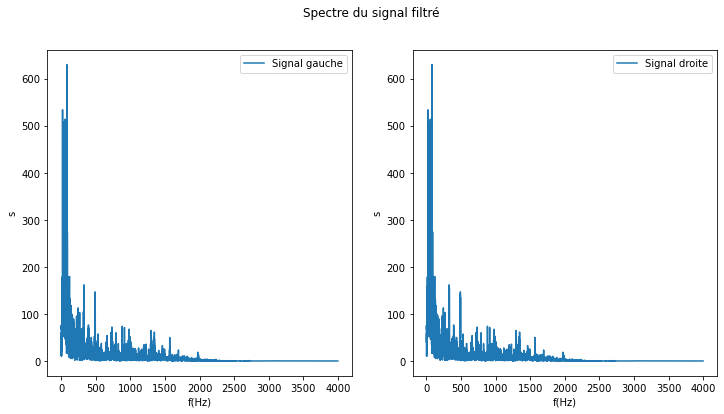

In [7]:
"""Tracé fréquentielle"""
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Spectre du signal filtré")
ax[0].set_xlabel("f(Hz)")
ax[0].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[0].plot(freqs_g, samps_g, label="Signal gauche")
ax[0].legend()
ax[1].set_xlabel("f(Hz)")
ax[1].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[1].plot(freqs_d, samps_d, label="Signal droite")
ax[1].legend()
plt.show()

* On a beaucoup atténué les hautes fréquences comme attendu.
* Le contenu spectral à basse fréquence semble relativement peut touché.

In [9]:
%%time
"""Reconstruction des signaux temporels
On utilise les fonctions données au début. On a besoin de calculer le temps final.
npt est le nombre du points du signal d'entrée.
C'est cette cellule qui peut prendre du temps.
"""
tf = npt / samplerate  # Temps final du signal
st_g, s_gauche = evalue_temp(freqs_g, samps_g, sphis_g, 0, tf, npt)
st_d, s_droite = evalue_temp(freqs_d, samps_d, sphis_d, 0, tf, npt)

0 %
20 %
40 %
60 %
79 %
99 %
0 %
20 %
40 %
60 %
79 %
99 %
CPU times: user 14.1 s, sys: 19.5 ms, total: 14.1 s
Wall time: 14.1 s


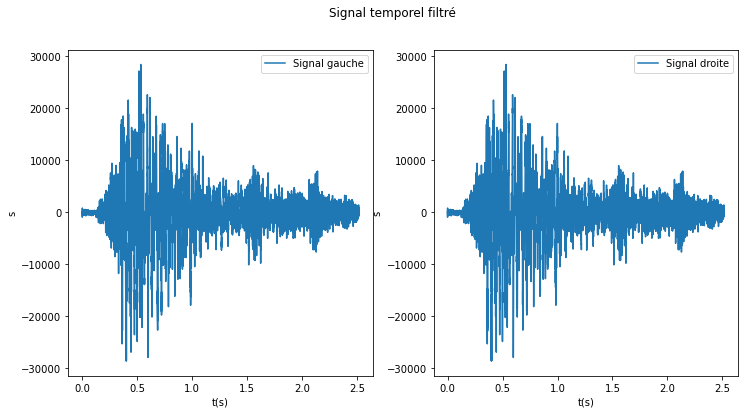

In [10]:
"""Tracé temporel"""
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Signal temporel filtré")
ax[0].set_xlabel("t(s)")
ax[0].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[0].plot(st_g, s_gauche, label="Signal gauche")
ax[0].legend()
ax[1].set_xlabel("t(s)")
ax[1].set_ylabel("s")  # Le signal numérisé n'a pas vraiment d'unité physique
ax[1].plot(st_d, s_droite, label="Signal droite")
ax[1].legend()
plt.show()

### Création du fichier sonore
Si tout à été fait correctement, la cellule ci-dessous peut-être exécutée directement. Elle va créer un fichier sonore `.wav` à partir du signal filtré. Il ne vous reste plus qu'à écouter le signal ainsi obtenu pour vérifier qu'on a bien filtré le bruit parasite.

In [11]:
# On doit normaliser le signal pour que les valeurs soit comprises entre -1 et 1
# En pratique, on place les valeurs entre -0.5 et 0.5 pour éviter tout risque de saturation
reponse2 = []
reponse2.append(s_gauche/ np.max(s_gauche) * 0.5)
reponse2.append(s_droite/ np.max(s_droite) * 0.5)
reponse2 = np.array(reponse2)  # La fonction write impose l'utilisation d'un array


filesortie = 'signal_filtree.wav'  # Nom du fichier, il sera dans le même répertoire que votre notebook
write(filesortie, samplerate, reponse2.transpose())  # Ecriture du fichier, on doit inverser lignes et colonnes.

## Conclusion
Nous avons donc pu réaliser le traitement d'un signal. Même s'il a été fait sur des signaux numériques, ce traitement reste "analogique" au sens où il suit exactement le même procédé qu'un filtre analogique étudié en TP.

Cette méthode est néanmoins problématique car elle demande beaucoup de ressource et du temps de calcul (on n'a ici traité que 2s secondes de musique échantilonnée à 8kHz, ce qui est peu).

En pratique, le traitement d'un signal numérique se fait par des filtres __numériques__ qui s'applique directement sur le signal temporel échantillonné ($s_k$). Certains de ces filtre seront vus en deuxième année suivant les options. La bibliothèques `scipy` propose notamment plusieurs fonctions natives et optimisées pour le traitement des signaux numériques (sous bibliothèques `scipy.signal`).

On ne présente pas ici ces méthodes qui ne sont pas au programme mais sachez qu'on peut notamment utiliser un filtre de Butterworth ou son équivalent numérique grâce à cette bibliothèque.

In [11]:
import IPython
IPython.display.Audio("./sources/signal_bruitee_2.wav")

In [12]:
IPython.display.Audio("./signal_filtree.wav")

In [13]:
help(write)

Help on function write in module scipy.io.wavfile:

write(filename, rate, data)
    Write a NumPy array as a WAV file.
    
    Parameters
    ----------
    filename : string or open file handle
        Output wav file.
    rate : int
        The sample rate (in samples/sec).
    data : ndarray
        A 1-D or 2-D NumPy array of either integer or float data-type.
    
    Notes
    -----
    * Writes a simple uncompressed WAV file.
    * To write multiple-channels, use a 2-D array of shape
      (Nsamples, Nchannels).
    * The bits-per-sample and PCM/float will be determined by the data-type.
    
    Common data types: [1]_
    
    =====================  ===========  ===========  =============
         WAV format            Min          Max       NumPy dtype
    =====================  ===========  ===========  =============
    32-bit floating-point  -1.0         +1.0         float32
    32-bit PCM             -2147483648  +2147483647  int32
    16-bit PCM             -32768      